This notebook is dedicated to the implementation of the value-iteraton and policy-iteration applied against the warehouse problem.

In [ ]:
import pandas as pd
import numpy as np
import random
import time
import matplotlib.pyplot as plt


In [2]:
class modelIteration(object):
    def __init__(self):
        self.reward=-1
        self.val_reward=[]
        self.delta=[]
        self.rand=0  #prob does not move in selected direction
        #file= open("data/myworld.csv")
        file=open("data/world01.csv")
        self.world = np.array([list( s.strip().split(",")) for s in file.readlines()])
        file.close()
        self.moves=[(1,0),(0,-1),(-1,0),(0,1)] #down,left,up,right
        self.world=self.world.astype(float)
        self.num_rows = self.world.shape[0]
        self.num_cols = self.world.shape[1]
        self.world_list=self.world.tolist()        
        self.tot_actions=len(self.moves)
        self.pol_updates=[]
        #self.policy = [[random.randint(-10, self.tot_actions-1) for j in range(self.num_cols)] for i in range(self.num_rows)] # construct a random policy
        self.policy = [[0 for j in range(self.num_cols)] for i in range(self.num_rows)] # construct a random policy
        self.goal_state=[]
        self.terminal_states=[]  #used
        for r in range(self.num_rows):
            for c in range(self.num_cols):
                if self.world_list[r][c]==100:
                    self.goal_state.append((r,c))
                if abs(self.world_list[r][c])==100:
                    self.terminal_states.append((r,c))


    def new_pos(self,row,col,move):
        r,c=self.moves[move]
        new_row=row+r
        new_col=col+c
        #print(r," ",c,":",new_row," ",new_col)
        if new_row<0 or new_col<0 or new_row>=self.num_rows or new_col>=self.num_cols:
            return row, col
        else:
            return new_row, new_col
    
    #updated utility value after action
    def new_Q(self,row,col,move,gamma):
        new_row,new_col=self.new_pos(row,col,move)
        new_Q=self.reward+gamma*self.world_list[new_row][new_col]   
        return new_Q    


#policy iteration    
    def pol_valIteration(self,gamma,eps):
        Q_update=self.world.tolist()
        while True:    
            error=0
            for r in range(self.num_rows):
                for c in range(self.num_cols):
                    coord=(r,c)
                    if coord in self.terminal_states: 
                        pass
                    else:
                        Q_update[r][c]=self.new_Q(r,c,self.policy[r][c],gamma)
                        error = max(error, abs(Q_update[r][c]-self.world_list[r][c]))
            self.world_list=Q_update
            if error<eps:
                break
        #return self.world_list   

    def policyIteration(self,gamma,eps):
        while True:            
            counter=0
            no_updates=True
            self.pol_valIteration(gamma,eps)
            for r in range(self.num_rows):
                for c in range(self.num_cols):
                   # print('r ',r,' c ',c,' wl ',self.world_list[r][c])
                    best_action, bestQ=None, float('-inf')
                    coord=(r,c)
                    if coord in self.terminal_states:    
                           pass
                    else:
                        for action in range(self.tot_actions):
                            q=self.new_Q(r,c,action,gamma)
                            if q>bestQ:
                                best_action,bestQ=action,q     
                        if bestQ>self.new_Q(r,c,self.policy[r][c],gamma):
                            self.policy[r][c]=best_action
                            no_updates=False 
                            counter=counter+1
            if no_updates==True:
                break
            self.pol_updates.append(counter)    
        final_policy=self.policy        
        return final_policy       

 ##value iteration
    def valIteration(self,gamma,eps):
            counter=0
            while True:
                counter=counter+1
                error=0
                Q_update=self.world.tolist()
                for r in range(self.num_rows):
                    for c in range(self.num_cols):
                        coord=(r,c)
                        if coord in self.terminal_states: 
                            pass
                        else:
                            Q_update[r][c]=max(self.new_Q(r,c,mv,gamma) for mv in range(self.tot_actions))
                            error = max(error, abs(Q_update[r][c]-self.world_list[r][c]))
                self.world_list=Q_update
                self.delta.append(error)
                temp_reward=0
                for r in range(self.num_rows):
                    for c in range(self.num_cols):
                        coord=(r,c)
                        if coord in self.terminal_states: 
                            pass
                        else:
                            temp_reward=temp_reward+Q_update[r][c]
                self.val_reward.append(temp_reward)
                if error<eps:
                    break
            print("iterations ",counter)        
            return self.world_list   

    def color_red(self, val):
        color='black' if val=="*" else 'red'
        return 'color: %s' % color
        
    def print_matrix(self, policy):
        direction_mat=[[0 for x in range(self.num_cols)] for y in range(self.num_rows)] 
        for r in range(self.num_rows):
            for c in range(self.num_cols):
                a=policy[r][c]
                coord=(r,c)
                if coord in self.goal_state:
                    direction_mat[r][c]="G"
                elif coord in self.terminal_states:
                    direction_mat[r][c]="*"
                elif a==0:
                    direction_mat[r][c]='\u2193'
                elif a==1:
                    direction_mat[r][c]='\u2190'
                elif a==2:
                    direction_mat[r][c]='\u2191'
                elif a==3:
                    direction_mat[r][c]='\u2192'
                else:
                    direction_mat[r][c]='err'
        return direction_mat    

    def getOptimalPolicy(self,gamma):
       # policy = [[-1, -1, -1, -1] for i in range(self.num_rows)]
        policy=[[-1 for x in range(self.num_cols)] for y in range(self.num_rows)] 
        for r in range(self.num_rows):
            for c in range(self.num_cols):
                coord=(r,c)
                if coord in self.terminal_states:    
                    pass
       #         # Choose the action that maximizes the utility
                maxAction, maxU = None, -float("inf")
                for action in range(self.tot_actions):
                    u = self.new_Q(r,c,action,gamma)
                    if u > maxU:
                        maxAction, maxU = action, u
                policy[r][c] = maxAction
        return policy
#        self.print_matrix(policy)
        
    def plot_policy_stats(self):
        updates=self.pol_updates
        updates.append(0)
        ax=plt.axes()
        plt.plot(updates, color="b",
        label="Updates per Sweep")
        plt.ylabel('Number of Updates')
        plt.xlabel('Sweep #')
        plt.title("Number of updates per sweep ")
        plt.show()    
        
    def plot_val_stats(self):
        delta=self.delta
        ax=plt.axes()
        plt.plot(delta, color="b",
        label="Delta")
        plt.ylabel('Delta')
        plt.xlabel('Iteration')
        plt.title("Calculated Error update (Delta) per iteration ")
        plt.show()    
        
        rewrd=self.val_reward
        ax=plt.axes()
        plt.plot(rewrd, color="b",
        label="reward")
        plt.ylabel('Calculated Reward')
        plt.xlabel('Iteration')
        plt.title("Calculated Reward per iteration ")
        
        plt.show()    
    

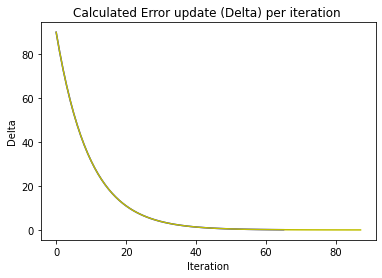

In [38]:
delta11=modIt.delta
ax=plt.axes()
plt.plot(delta1, color="b",label="eps=.1")
plt.plot(delta11, color="y",label="eps=.1")
plt.ylabel('Delta')
plt.xlabel('Iteration')
plt.title("Calculated Error update (Delta) per iteration ")
plt.show()  
#.1 3.95sec 66 iterations
#.01 5.33 88
#.001 5.78 92

iterations  66
Value Iteration Converged in 4.0257 seconds


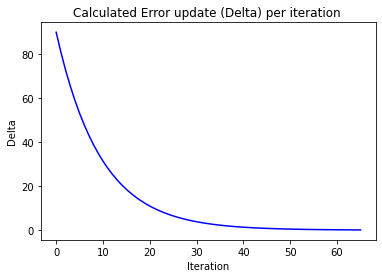

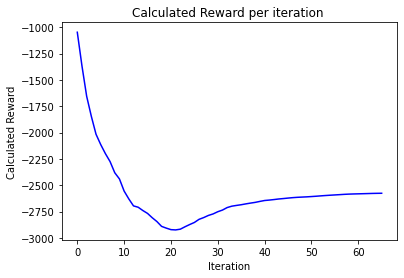

In [40]:
modIt=modelIteration()
gamma=.9
epsilon=.1
tic = time.perf_counter()
modIt.valIteration(gamma,epsilon)  #parameters are gamma and epsilon
toc = time.perf_counter()
print(f"Value Iteration Converged in {toc - tic:0.4f} seconds")
modIt.plot_val_stats()


In [32]:
#after above is executed this will print out the policy for value iteration
A=modIt.getOptimalPolicy(gamma)
B=modIt.print_matrix(A)
B=pd.DataFrame(B)
B.style.applymap(modIt.color_red)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30
0,*,*,*,*,*,G,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*
1,*,→,→,→,→,↑,←,←,←,←,*,*,↓,←,←,→,→,→,↓,←,←,*,*,→,→,→,→,↓,←,←,*
2,*,↑,*,*,*,*,*,↑,*,↑,*,*,↓,*,*,*,*,*,↓,*,↑,*,*,*,*,*,*,↓,*,↑,*
3,*,↑,←,←,→,→,→,↑,*,↑,*,*,→,→,↓,←,←,→,↓,*,↑,*,*,↓,←,←,→,↓,*,↑,*
4,*,*,*,↑,*,*,*,↑,*,*,*,*,*,*,↓,*,*,*,↓,*,*,*,*,↓,*,*,*,↓,*,*,*
5,→,→,→,↑,→,→,→,↑,←,←,←,*,→,→,→,→,↓,←,←,←,←,←,*,→,→,↓,←,←,←,←,←
6,*,*,*,*,*,↑,*,*,*,*,*,*,*,*,*,*,↓,*,*,*,*,*,*,*,*,↓,*,*,*,*,*
7,*,→,→,→,→,↑,←,←,←,←,*,*,→,→,↓,←,←,←,↓,←,←,*,*,*,→,→,→,↓,←,←,*
8,*,*,*,↑,*,*,*,↑,*,*,*,*,*,*,↓,*,*,*,↓,*,*,*,*,↓,*,*,*,↓,*,*,*
9,→,→,→,↑,←,←,→,↑,←,←,←,←,←,←,←,←,←,←,←,←,←,←,*,→,→,↓,←,←,←,←,←


Policy Iteration Maze Solution 

Policy Iteration Converged in 4.3764 seconds
Policy Iteration Plot


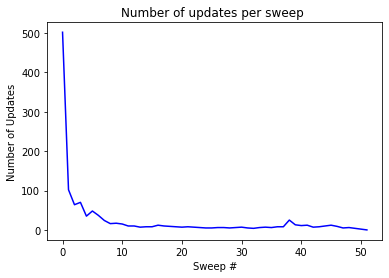

In [67]:
modIt=modelIteration()
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_rows', None)
print("Policy Iteration Maze Solution \n")
tic = time.perf_counter()
A=modIt.policyIteration(.8,.001)
toc = time.perf_counter()

print(f"Policy Iteration Converged in {toc - tic:0.4f} seconds")
      
print("Policy Iteration Plot")
modIt.plot_policy_stats()

#modIt.valIteration()
#print("value iteration")
#modIt.getOptimalPolicy()
#print("\n policyiteration")



In [66]:
B=pd.DataFrame(A)
B=modIt.print_matrix(A)
B=pd.DataFrame(B)
B.style.applymap(modIt.color_red)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30
0,*,*,*,*,*,G,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*
1,*,→,→,→,→,↑,←,←,←,←,*,*,↓,←,→,→,→,→,↓,←,←,*,*,→,→,→,→,↓,←,←,*
2,*,↑,*,*,*,*,*,↑,*,↑,*,*,↓,*,*,*,*,*,↓,*,↑,*,*,*,*,*,*,↓,*,↑,*
3,*,↑,←,←,→,→,→,↑,*,↑,*,*,→,→,↓,←,→,→,↓,*,↑,*,*,↓,←,→,→,↓,*,↑,*
4,*,*,*,↑,*,*,*,↑,*,*,*,*,*,*,↓,*,*,*,↓,*,*,*,*,↓,*,*,*,↓,*,*,*
5,→,→,→,↑,→,→,→,↑,←,←,←,*,→,→,→,→,↓,←,←,←,←,←,*,→,→,↓,←,←,←,←,←
6,*,*,*,*,*,↑,*,*,*,*,*,*,*,*,*,*,↓,*,*,*,*,*,*,*,*,↓,*,*,*,*,*
7,*,→,→,→,→,↑,←,←,←,←,*,*,→,→,↓,←,←,←,←,←,←,*,*,*,→,→,→,↓,←,←,*
8,*,*,*,↑,*,*,*,↑,*,*,*,*,*,*,↓,*,*,*,↓,*,*,*,*,↓,*,*,*,↓,*,*,*
9,→,→,→,↑,←,→,→,↑,←,←,←,←,←,←,←,←,←,←,←,←,←,←,*,→,→,↓,←,←,←,←,←


In [69]:
modIt.policy

[[0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 [0,
  3,
  3,
  3,
  3,
  2,
  1,
  1,
  1,
  1,
  0,
  0,
  0,
  1,
  3,
  3,
  3,
  3,
  0,
  1,
  1,
  0,
  0,
  3,
  3,
  3,
  3,
  0,
  1,
  1,
  0],
 [0,
  2,
  0,
  0,
  0,
  0,
  0,
  2,
  0,
  2,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  2,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  2,
  0],
 [0,
  2,
  1,
  1,
  3,
  3,
  3,
  2,
  0,
  2,
  0,
  0,
  3,
  3,
  0,
  1,
  3,
  3,
  0,
  0,
  2,
  0,
  0,
  0,
  1,
  3,
  3,
  0,
  0,
  2,
  0],
 [0,
  0,
  0,
  2,
  0,
  0,
  0,
  2,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 [3,
  3,
  3,
  2,
  3,
  3,
  3,
  2,
  1,
  1,
  1,
  0,
  3,
  3,
  3,
  3,
  0,
  1,
  1,
  1,
  1,
  1,
  0,
  3,
  3,
  0,
  1,
  1,
  1,
  1,
  1],
 [0,
  0,
  0,
  0,
  0,
  2,
  0,
  0,
  0,
  0,
  0,
  0,
  0,